In [98]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# **R4: Multiple Products Adversarial Environment**

Multiple Products pricing against adversarial buyer with predetermined valuation sequences.

## Adversarial Buyer Model

Buyer with predetermined valuation sequence.

In [13]:
class AdversarialBuyer:
    def __init__(self, valuation_sequences):
        self.valuation_sequences = valuation_sequences  # shape: (T, N)
        self.t = 0
        self.T, self.N = valuation_sequences.shape

    def round(self, prices):
        if self.t >= self.T:
            return np.zeros(self.N, dtype=int)  # No purchases after T rounds

        valuations = self.valuation_sequences[self.t]  # shape: (N,)
        self.t += 1

        return (prices < valuations).astype(int)  # shape: (N,)

    def reset(self):
        self.t = 0

In [14]:
def generate_adversarial_sequence(T, strategy):
    if strategy == 'oscillating':
        return np.array([0.4 if t % 2== 0 else 0.8 for t in range(T)])
    
    elif strategy == 'delayed_reward':
        return np.concatenate([np.full(T//2, 0.2), np.full(T//2, 0.8)])
    
    elif strategy == 'random_adversarial':
        np.random.seed(42)
        return np.random.uniform(0, 1, T)
    
    elif strategy == 'custom_pattern': 
        sequence = np.zeros(T)
        for t in range(T):
            if t < T // 3:
                sequence[t] = 0.3
            elif t < 2 * T // 3:
                sequence[t] = 0.7+t/T/10-0.30
            else:
                sequence[t] = 0.5
        return sequence
    
    else:
        raise ValueError(f"Unknown strategy: {strategy}")


def apply_noise(sequence, sigma):
    return np.random.multivariate_normal(sequence, sigma)

def generate_adversarial_valuations(N, T, sigma):
    strategies = ['oscillating', 'delayed_reward', 'random_adversarial', 'custom_pattern']
    sequences = []

    for _ in range(N):
        strategy = np.random.choice(strategies)
        sequence = generate_adversarial_sequence(T, strategy)
        sequences.append(sequence)

    valutaions = []
    for t in range(T):
        noisy_sequence = apply_noise(np.array(sequences)[:, t], sigma)
        valutaions.append(noisy_sequence)

    return np.array(valutaions)

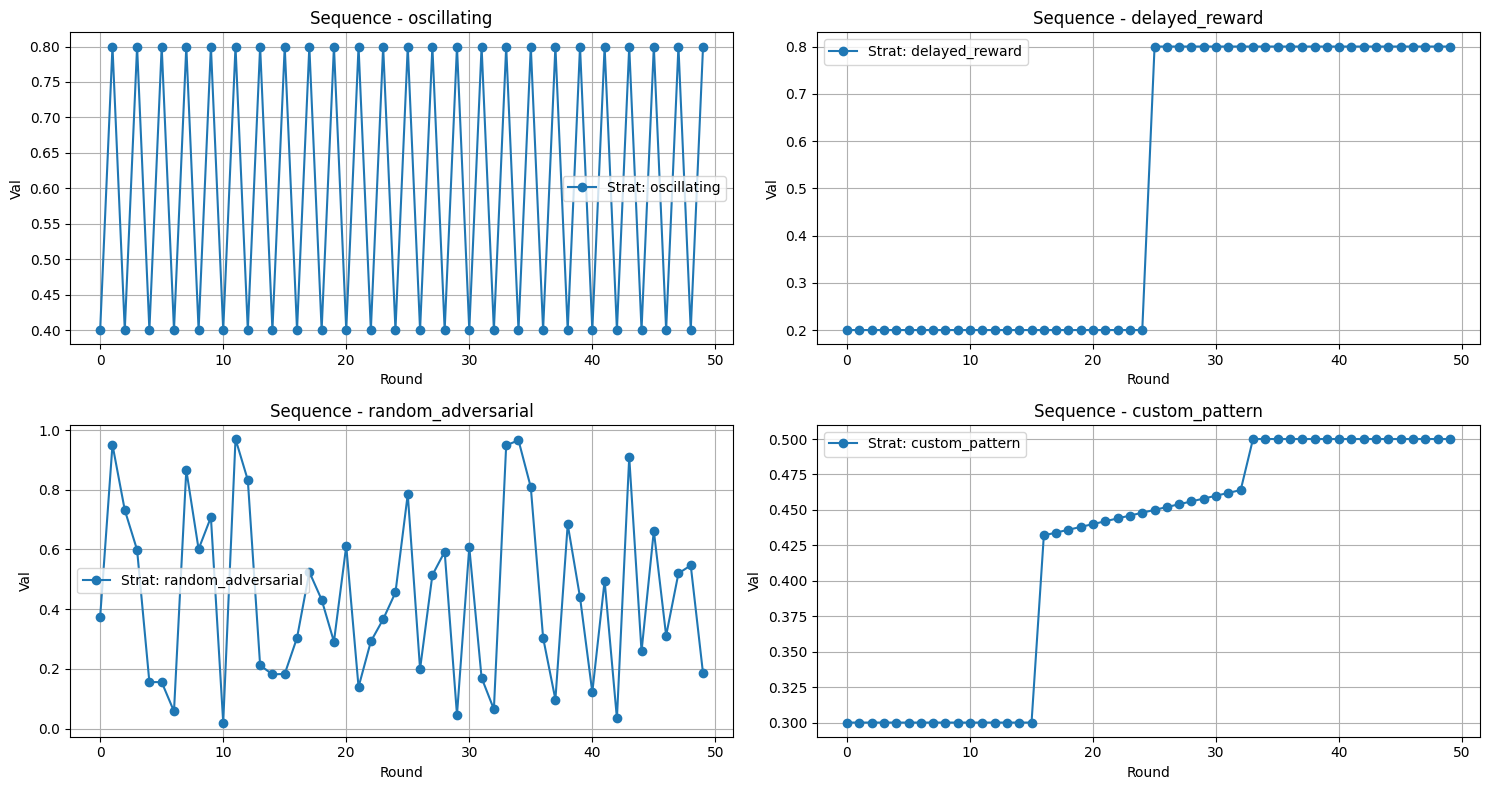

In [15]:
T_test = 50
strategies = ['oscillating', 'delayed_reward', 'random_adversarial', 'custom_pattern']

fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

for i, strategy in enumerate(strategies):
    valuation_sequence = generate_adversarial_sequence(T_test, strategy)    
    axes[i].plot(valuation_sequence, marker='o', label=f'Strat: {strategy}')
    axes[i].set_title(f'Sequence - {strategy}')
    axes[i].set_xlabel('Round')
    axes[i].set_ylabel('Val')
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()

## **V1:** Multiplicative Pacing

first idea is tu use the pacing strategy

In [16]:
T = 50
sigma = np.array([[0.1, 0.05, 0.02],
                  [0.05, 0.1, 0.03],
                  [0.02, 0.03, 0.1]])
valuations = generate_adversarial_valuations(3, T, sigma)
valuations.shape

(50, 3)

## Optimal Strategy

optimal price maximizing revenue subject to capacity constraint.

In [ ]:
def compute_baseline(T, N, P, B, evaluations):
    rho = B / T  # total allowed cost per round
    K = len(P)

    f_all = np.zeros((N, K))  # expected profit
    c_all = np.zeros((N, K))  # expected cost (sale rate)

    # Compute expected profit and cost for each agent and price
    for n in range(N):
        for k in range(K):
            total_profit = 0
            num_sales = 0
            for t in range(T):
                if evaluations[t][n] >= P[k]:
                    num_sales += 1
                    total_profit += P[k]
            f_all[n][k] = total_profit / T
            c_all[n][k] = num_sales / T

    best_combo = None
    best_f_sum = -np.inf

    for combo in itertools.product(range(K), repeat=N):
        f_sum = sum(f_all[n][combo[n]] for n in range(N))
        c_sum = sum(c_all[n][combo[n]] for n in range(N))

        if c_sum < rho and f_sum > best_f_sum:
            best_f_sum = f_sum
            best_combo = combo

    best_prices = [P[i] for i in best_combo] if best_combo else None
    return best_prices, best_f_sum

In [102]:
T = 50
sigma = np.array([[0.1, 0.05, 0.02],
                  [0.05, 0.1, 0.03],
                  [0.02, 0.03, 0.1]])
valuations = generate_adversarial_valuations(3, T, sigma)
compute_baseline(T, 3, np.linspace(0, 1, 11), 25, valuations)
buyer = AdversarialBuyer(valuations)
buyer.round([0.1, 0.5, 0.9])

array([1, 0, 0])

## Agent: 

Modify R3 V1 to be consistent with multiple products

In [103]:
class EXP3Agent:
    def __init__(self, K, learning_rate=0.1):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [104]:
class Company:
    def __init__(self, N, K, B, T, learning_rate=0.5):
        self.N = N                                # number of products
        self.K = K                                # number of prices
        self.B = B
        self.T = T                                # number of rounds
        self.P = np.linspace(0, 1, K)             # price options
        self.rho = B / T                          # cost per round
        self.learning_rate = learning_rate

        self.agents = [EXP3Agent(K) for _ in range(N)]  # agent per product
        self.lmbd = np.zeros(N)                         # lambda per product
        self.p_idx = np.zeros(N, dtype=int)             # current price index per product
        self.N_pulls = np.zeros((N, K))                 # pull counts

    def pull_arms(self):
        for i in range(self.N):
            if self.B < 1:
                self.p_idx[i] = 0  
            else:
                self.p_idx[i] = self.agents[i].pull_arm()
        return self.p_idx

    def update(self, f_t, c_t):
        for i in range(self.N):
            idx = self.p_idx[i]
            L = f_t[i] - self.lmbd[i] * (c_t[i] - self.rho)

            # Rescale L to [0, 1]
            L_up = 1 - (1 / self.rho) * (-self.rho)
            L_low = 0 - (1 / self.rho) * (1 - self.rho)
            rescaled_L = (L - L_low) / (L_up - L_low)

            # Update agent
            self.agents[i].update(1 - rescaled_L)

            # Update lambda
            self.lmbd[i] = np.clip(self.lmbd[i] - self.learning_rate * (self.rho - c_t[i]), 0, 1 / self.rho)

            # Update budget and stats
            self.B -= c_t[i]
            self.N_pulls[i, idx] += 1

## Simulation

EXP3 performance against adversarial valuation sequences.


In [110]:
T = 50000
B = 80000
N = 3
P = np.linspace(0, 1, 11)
K = len(P)

sigma = np.array([[0.1, 0.05, 0.02],
                  [0.05, 0.1, 0.03],
                  [0.02, 0.03, 0.1]])

valuations = generate_adversarial_valuations(3, T, sigma)
best_prices, exp_utility = compute_baseline(T, N, P, B, valuations)

print("best_price:", best_prices)
print("expected utility:", exp_utility)

n_trials = 5

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)

    # Create adversarial buyer with the predefined sequence
    buyer = AdversarialBuyer(valuations)
    agent = Company(N=N, K=K, B=B, T=T, learning_rate=0.1)
    ag_utility = np.zeros(T)

    flag = True
    for i in range(T):
        arms = agent.pull_arms()
        prices = P[arms]

        sold = buyer.round(prices)

        f_t = np.zeros(N)  # reward: revenue
        c_t = np.zeros(N)  # cost: unit consumed
        for id, p in enumerate(prices):
            #print(f"Round {i}, Product {id}, Price: {p}, Sold: {sold[id]}")
            f_t[id] = p if sold[id] else 0        # reward: revenue
            c_t[id] = 1 if sold[id] else 0        # cost: unit consumed

        agent.update(f_t=f_t, c_t=c_t)

        #print("Round", i, "Prices:", prices, "Sold:", sold, "Budget:", agent.B)

        ag_utility[i] = np.sum(f_t)

        if agent.B <= 0 and flag:
            print("TRIAL", seed , "Budget exhausted at round", i)
            flag = False

    # Reset buyer for next trial
    buyer.reset()
    
    cumulative_regret = np.cumsum(exp_utility-ag_utility)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)

print("Agent Cumulative Reward", np.sum(ag_utility))
print("Average cumulative regret", average_regret[-1])

best_price: [np.float64(0.6000000000000001), np.float64(0.5), np.float64(0.6000000000000001)]
expected utility: 0.8467580000001875
Agent Cumulative Reward 30870.800000000003
Average cumulative regret 10826.220000006651


## Results V1

EXP3 achieves sublinear regret with O(sqrt(KT log K)) bound in adversarial environments.

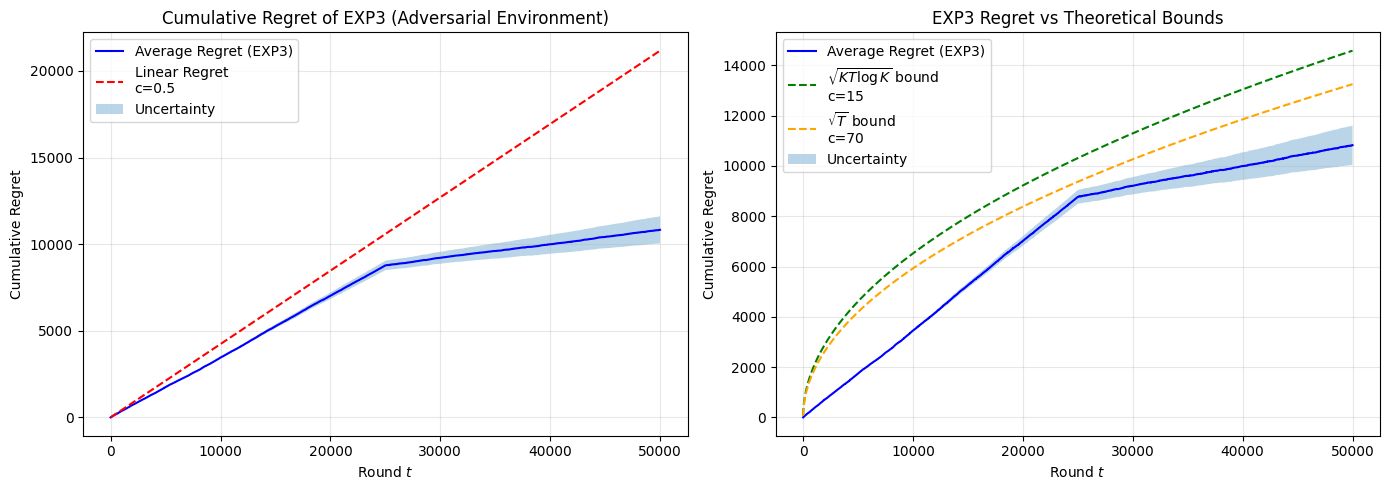

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# First subplot: Cumulative regret with linear line 
axs[0].plot(np.arange(T), average_regret, label='Average Regret (EXP3)', color='blue')
axs[0].set_title('Cumulative Regret of EXP3 (Adversarial Environment)')

c_linear = 0.5
linear_regret = np.arange(T) * exp_utility * c_linear # Linear regret line
axs[0].plot(np.arange(T), linear_regret, label=f'Linear Regret\nc={c_linear}', linestyle='--', color='red')
axs[0].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
axs[0].set_xlabel('Round $t$')
axs[0].set_ylabel('Cumulative Regret')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Second subplot: EXP3 theoretical bounds
axs[1].plot(np.arange(T), average_regret, label='Average Regret (EXP3)', color='blue')
axs[1].set_title('EXP3 Regret vs Theoretical Bounds')

t_vals = np.arange(1, T+1)

# EXP3 theoretical bound: O(sqrt(KT log K))
c_exp3 = 15
exp3_bound = np.sqrt(K * t_vals * np.log(K)) * exp_utility * c_exp3
axs[1].plot(np.arange(T), exp3_bound, label=f'$\\sqrt{{KT\\log K}}$ bound\nc={c_exp3}', linestyle='--', color='green')

# Simpler sqrt(T) bound for comparison
c_sqrt = 70
sqrt_bound = np.sqrt(t_vals) * exp_utility * c_sqrt
axs[1].plot(np.arange(T), sqrt_bound, label=f'$\\sqrt{{T}}$ bound\nc={c_sqrt}', linestyle='--', color='orange')

# Fill between for uncertainty in the second plot
axs[1].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)

# Set labels and legends for the second subplot
axs[1].set_xlabel('Round $t$')
axs[1].set_ylabel('Cumulative Regret')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()